In [2]:
# Standard Library Imports
from __future__ import print_function
from time import time
import os
import gc

# Third-Party Library Imports
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, classification_report, confusion_matrix

# Keras and TensorFlow Imports
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

## Files


In [3]:
def resize_files(src_dir, dst_dir, size=(224,224)):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    files = os.listdir(src_dir)
    total_files = len(files)
    print("Found {} files".format(total_files))

    for i, file in enumerate(files, start=1):
        img_path = os.path.join(src_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(img,(224,224))
        output_path = os.path.join(dst_dir, file)
        if os.path.exists(output_path):
            print(f"Skipping {file} as it already exists.")
            continue
        
        cv2.imwrite(output_path, resized_img)
        if i%(total_files//20) == 0 or i == total_files:
            print(f"{i}/{total_files}")

In [4]:
main_dir = 'D:\\Downloads\\xrays'
output_dir = main_dir+'\\images'
images_dir = main_dir+'\\raw'
res_image_size = (224,224)

In [5]:
if len(os.listdir(output_dir))==0:
    for dir in os.listdir(images_dir):
        input_dir = os.path.join(images_dir,dir,'images')
        print(str(input_dir))
        resize_files(input_dir,output_dir,res_image_size)
        print('='*40)
image_files = os.listdir(output_dir)
print(len(image_files), 'images reshaped')

54996 images reshaped


In [6]:
df = pd.read_csv(main_dir+'\\xrays.csv')
print(df.shape)
df.head()

(112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [7]:
valid_indices = df['Image Index'].isin(image_files)
valid_df = df[valid_indices]
valid_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [8]:
file = 'sample_1_6.csv'
if not os.path.exists(file):
    valid_df.to_csv(file,index=False)
print(file,'saved with shape', valid_df.shape)

sample_1_6.csv saved with shape (54996, 12)


## Preprocess


In [9]:
csv_path = 'sample_1_6.csv'
df = pd.read_csv(csv_path)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [10]:
df['Finding Labels'].value_counts()

Finding Labels
No Finding                                                       31161
Infiltration                                                      3823
Atelectasis                                                       2098
Effusion                                                          1961
Nodule                                                            1325
                                                                 ...  
Atelectasis|Consolidation|Emphysema|Infiltration|Pneumothorax        1
Cardiomegaly|Infiltration|Nodule|Pneumonia                           1
Atelectasis|Hernia|Infiltration                                      1
Cardiomegaly|Mass|Nodule                                             1
Edema|Infiltration|Mass|Nodule|Pneumonia                             1
Name: count, Length: 567, dtype: int64

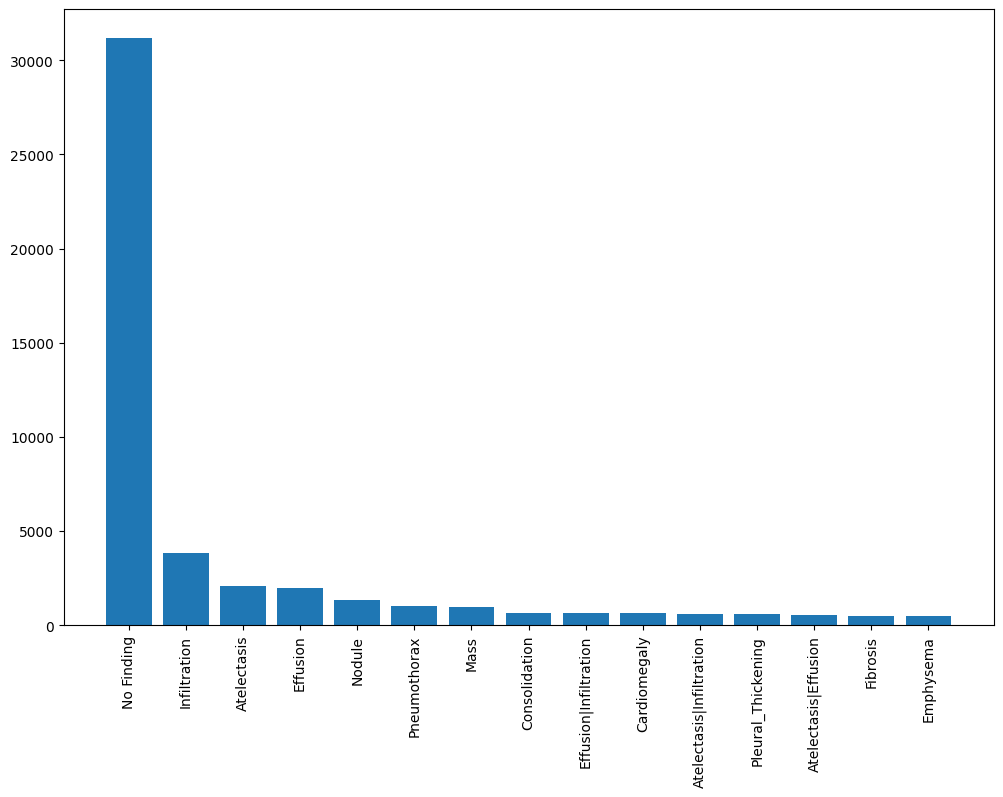

In [11]:
label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [12]:
df['No_Finding'] = df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0).astype(int)
df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
10399,00002701_001.png,,1,2701,50,F,PA,2048,2500,0.171,...,0,0,0,0,0,0,0,0,0,0
4471,00001208_002.png,,2,1208,29,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
1776,00000468_011.png,Pneumothorax,11,468,31,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,1


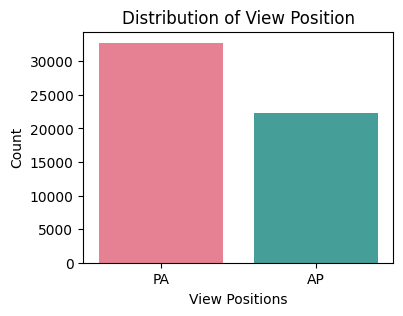

In [13]:
plt.figure(figsize=(4, 3))
sns.countplot(data=df, x='View Position', hue='View Position', palette='husl', legend=False)
plt.title('Distribution of View Position')
plt.xlabel('View Positions')
plt.ylabel('Count')
plt.show()

In [14]:
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'No_Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [15]:
df.drop(['Patient ID','OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],axis=1,inplace=True)

In [16]:
df.drop('Finding Labels',axis=1,inplace=True)
df.columns

Index(['Image Index', 'Follow-up #', 'Patient Age', 'Patient Gender',
       'View Position', 'No_Finding', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54999 entries, 0 to 54998
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image Index         54999 non-null  object
 1   Follow-up #         54999 non-null  int64 
 2   Patient Age         54999 non-null  int64 
 3   Patient Gender      54999 non-null  object
 4   View Position       54999 non-null  object
 5   No_Finding          54999 non-null  int64 
 6   Atelectasis         54999 non-null  int32 
 7   Cardiomegaly        54999 non-null  int32 
 8   Consolidation       54999 non-null  int32 
 9   Edema               54999 non-null  int32 
 10  Effusion            54999 non-null  int32 
 11  Emphysema           54999 non-null  int32 
 12  Fibrosis            54999 non-null  int32 
 13  Hernia              54999 non-null  int32 
 14  Infiltration        54999 non-null  int32 
 15  Mass                54999 non-null  int32 
 16  Nodule              54

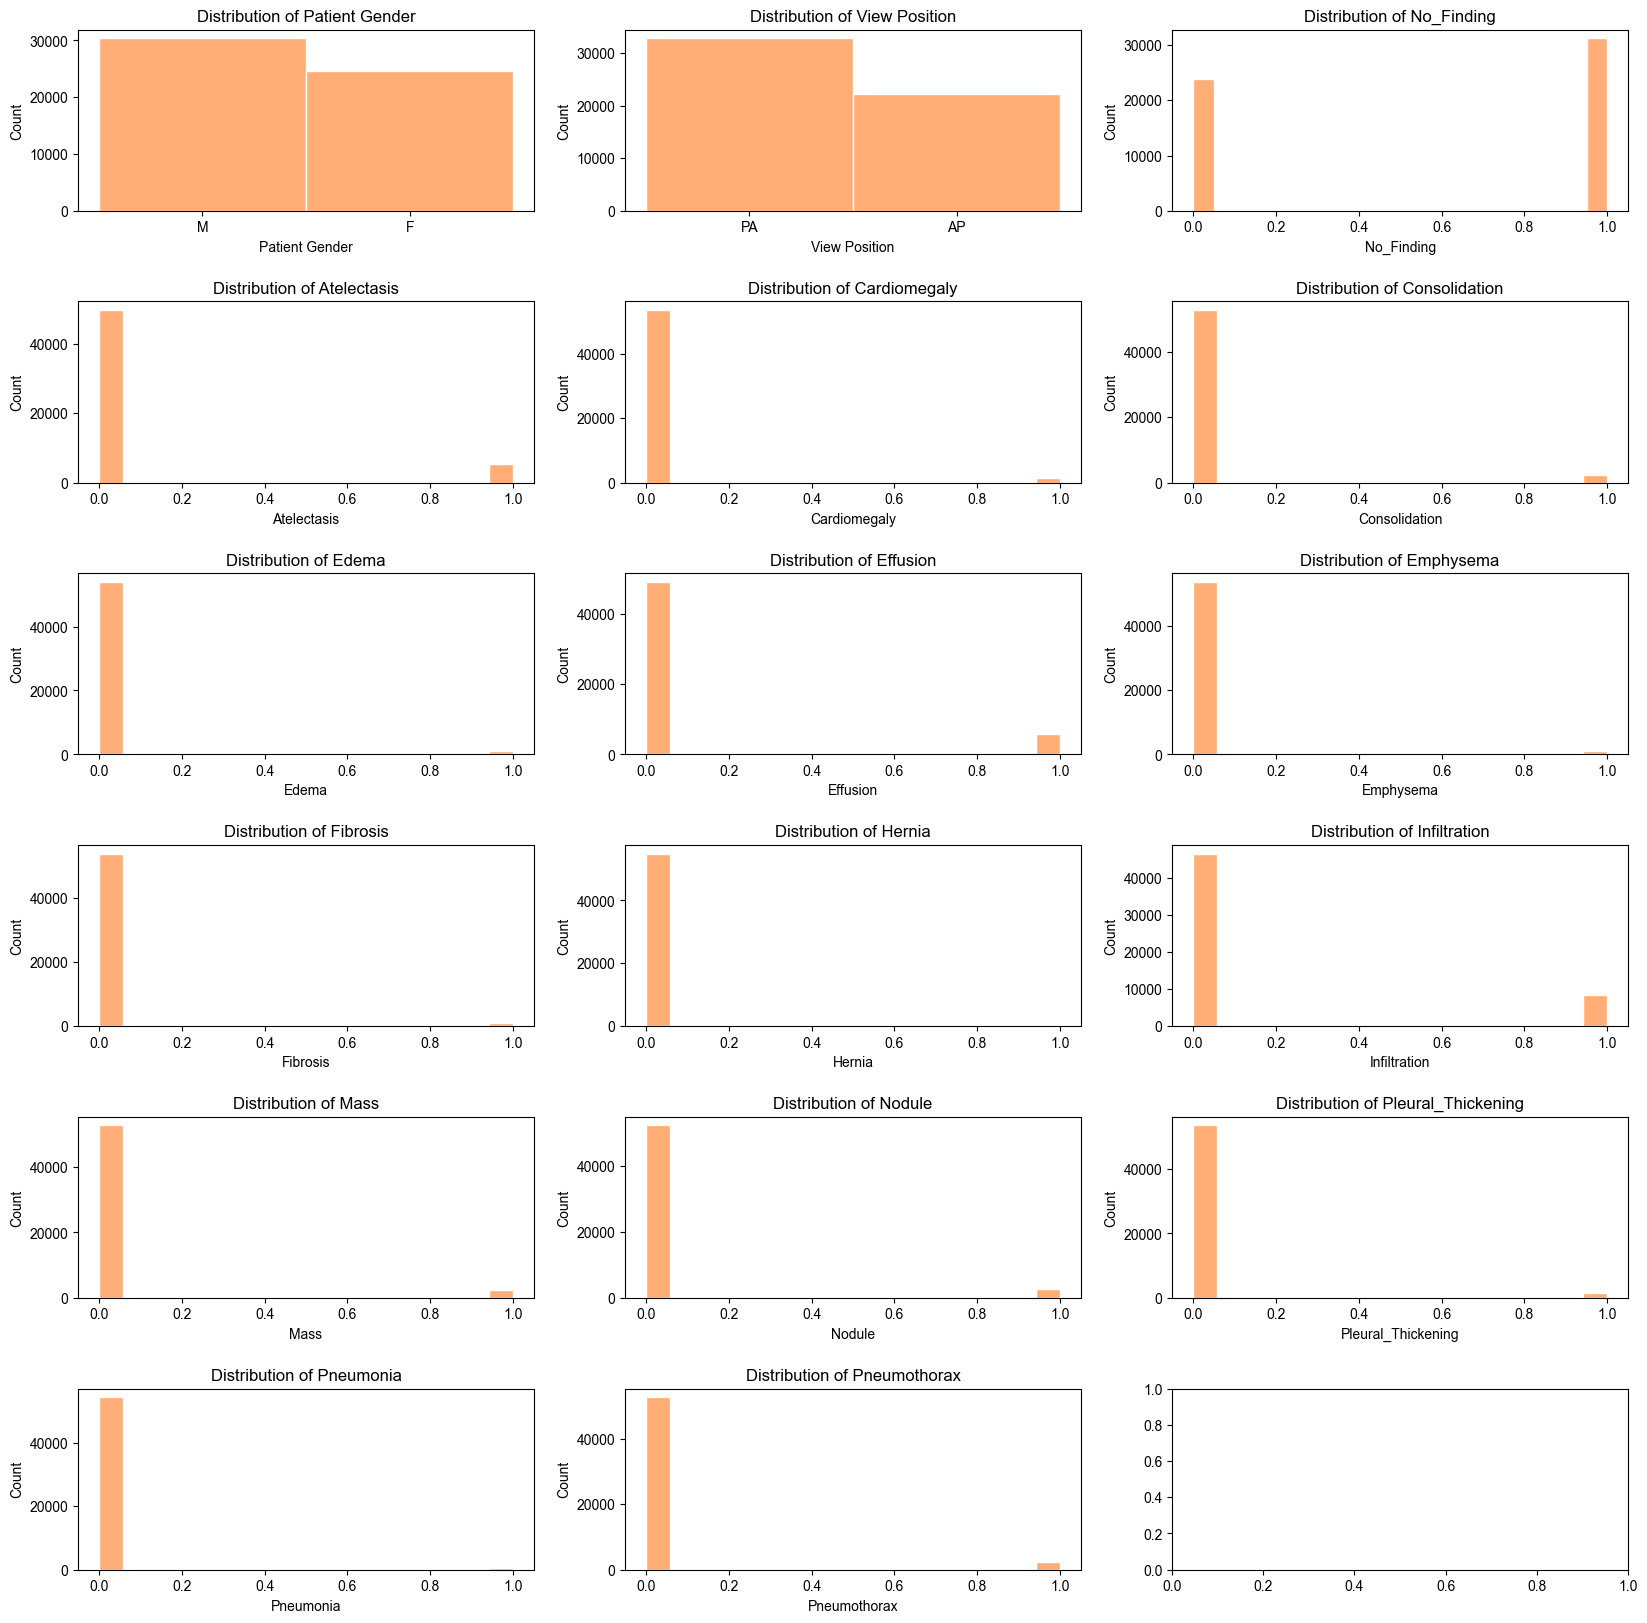

In [18]:
cols = df.drop(['Image Index','Follow-up #','Patient Age'],axis=1).columns
fig, axes = plt.subplots(6, 3, figsize=(20, 20))

sns.set(style="darkgrid")
axes = axes.flatten()

for i in range(len(cols)):
        sns.histplot(x=cols[i], data=df, color='#ff9248', ax=axes[i])
        axes[i].set_title(f'Distribution of {cols[i]}')
        axes[i].set_xlabel(cols[i])
        axes[i].set_ylabel('Count')

plt.subplots_adjust(hspace=.5)
plt.show()

In [19]:
df['Patient Gender'].replace({'M': 1, 'F': 0}, inplace=True)
df['View Position'].replace({'AP': 1, 'PA': 0}, inplace=True)
df.head()

,Image Index,Follow-up #,Patient Age,Patient Gender,View Position,No_Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,58,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,58,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,2,58,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,81,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,81,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [20]:
images_dir = 'D:\\Downloads\\xrays\\images'
image_files = os.listdir(images_dir)
age_gt_100 = df[df['Patient Age'] > 100]['Image Index'].tolist()
removed_num = 0
for filename in image_files:
    if filename in age_gt_100:
        file_path = os.path.join(images_dir, filename)
        os.remove(file_path)
        removed_num += 1
df = df[~df['Image Index'].isin(age_gt_100)]
print(removed_num,'images removed')

0 images removed


In [21]:
df['Patient Age'].sort_values() 

38783     1
39077     1
50004     1
25266     1
45965     1
         ..
5358     93
39016    93
578      94
576      94
577      94
Name: Patient Age, Length: 54996, dtype: int64

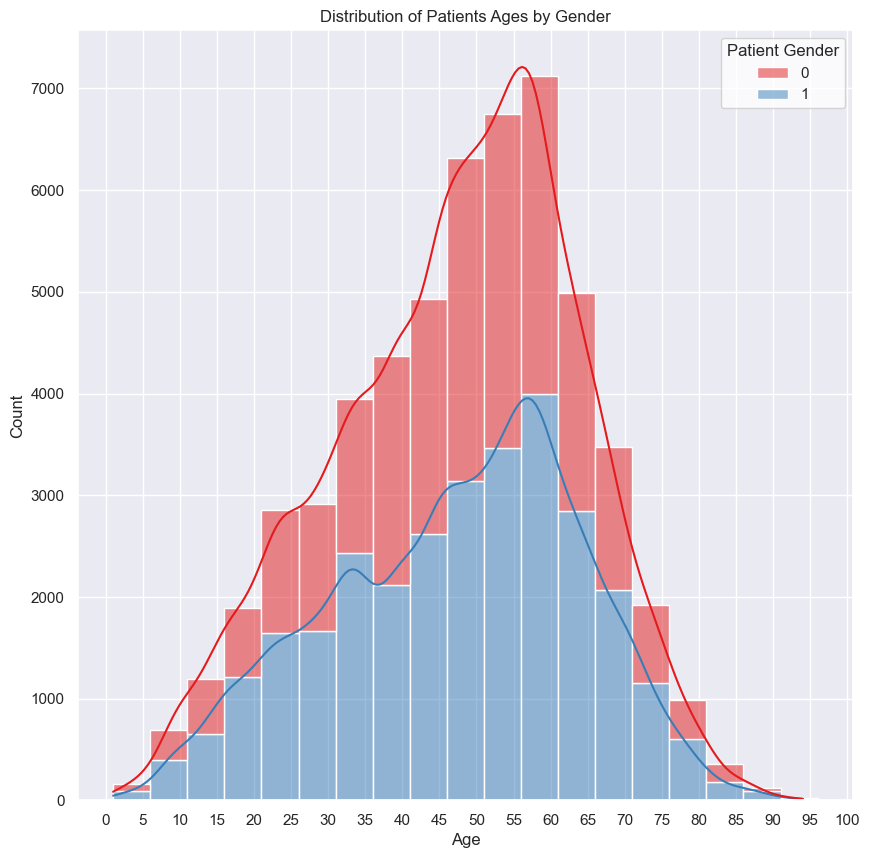

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.set_style('whitegrid')
sns.histplot(data=df, x='Patient Age', bins=range(df['Patient Age'].min(), min(df['Patient Age'].max(), 100) + 5, 5),
             hue='Patient Gender', multiple='stack', palette='Set1', kde=True)
plt.title(f'Distribution of Patients Ages by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(range(0, 101, 5))

plt.subplots_adjust(hspace=.5)
plt.show()

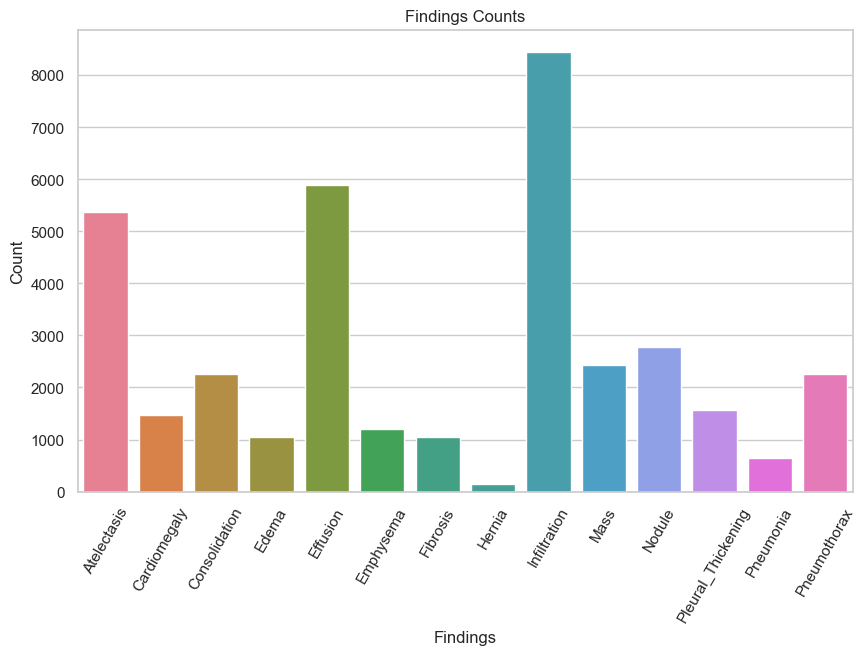

In [23]:
case_cols = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
counts = df[case_cols].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, hue=counts.index, y=counts.values,palette='husl')
plt.title('Findings Counts')
plt.xlabel('Findings')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

In [24]:
df.drop(columns=['Hernia','Follow-up #'],axis=1,inplace=True)
df.head()

,Image Index,Patient Age,Patient Gender,View Position,No_Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,58,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,58,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,00000001_002.png,58,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,00000002_000.png,81,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
print(df.shape)
print(df.columns)

(54996, 18)
Index(['Image Index', 'Patient Age', 'Patient Gender', 'View Position',
       'No_Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')


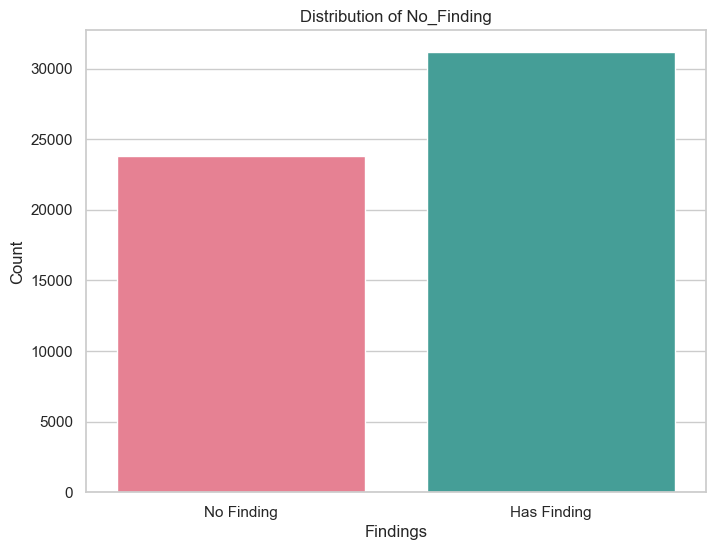

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='No_Finding', hue='No_Finding', palette='husl', legend=False)
plt.title('Distribution of No_Finding')
plt.xlabel('Findings')
plt.xticks([0, 1], ['No Finding', 'Has Finding'])
plt.ylabel('Count')
plt.show()

In [27]:
filename = 'xrays1_6.csv'
if not os.path.exists(filename):
    df.to_csv(filename,index=False)
print(filename,'saved with shape', df.shape)


xrays1_6.csv saved with shape (54996, 18)


## Pretraining


In [28]:
df = pd.read_csv('xrays1_6.csv')
df.head()

,Image Index,Patient Age,Patient Gender,No_Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,58,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,58,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,00000001_002.png,58,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,00000002_000.png,81,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df['No_Finding'].value_counts()

No_Finding
1    31160
0    23836
Name: count, dtype: int64

In [30]:
print(df.columns)
print(df.shape)

Index(['Image Index', 'Patient Age', 'Patient Gender', 'No_Finding',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')
(54996, 17)


In [31]:
labels = ['No_Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
image_folder = 'D:\\Downloads\\xrays\\images' # Folder containing the images
image_size = (224, 224, 1)  # Assuming images are resized to (224, 224)
y = df[labels].values

In [32]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [33]:
def load_and_process_images(df, image_folder, dst, y):
    batch_size = 32  # Adjust the batch size as needed

    num_images = len(df)
    num_batches = num_images // batch_size
    if num_images % batch_size != 0:
        num_batches += 1

    # Create folders for x_train, y_train, x_val, and y_val batches
    os.makedirs(os.path.join(dst, "x_trains"), exist_ok=True)
    os.makedirs(os.path.join(dst, "y_trains"), exist_ok=True)
    os.makedirs(os.path.join(dst, "x_vals"), exist_ok=True)
    os.makedirs(os.path.join(dst, "y_vals"), exist_ok=True)


    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, num_images)
        
        batch_X, batch_y = [], []
        for image_filename, label in zip(df['Image Index'].iloc[start_index:end_index], y[start_index:end_index]):
            img_path = os.path.join(image_folder, image_filename)
            img = load_img(img_path, color_mode='grayscale')
            img = img_to_array(img)
            batch_X.append(img / 255)
            batch_y.append(label)

        if batch_index % (num_batches // 20) == 0 or batch_index == num_batches - 1:
            print(f"Batch: {batch_index + 1}/{num_batches}")

        x_train_batch, x_val_batch, y_train_batch, y_val_batch = train_test_split(
            np.array(batch_X), np.array(batch_y),
            test_size=0.3,
            random_state=42
        )

        # Save each batch to separate files in respective folders
        np.save(os.path.join(dst, "x_trains", f"x_train_batch_{batch_index}.npy"), x_train_batch)
        np.save(os.path.join(dst, "y_trains", f"y_train_batch_{batch_index}.npy"), y_train_batch)
        np.save(os.path.join(dst, "x_vals", f"x_val_batch_{batch_index}.npy"), x_val_batch)
        np.save(os.path.join(dst, "y_vals", f"y_val_batch_{batch_index}.npy"), y_val_batch)

In [34]:
folder = 'D:\\Downloads\\xrays'
#load_and_process_images(df, image_folder, folder, y)

In [35]:
class ImageDataLoader:
    def __init__(self, image_folder, datagen, image_size=(224, 224, 3), batch_size=32):
        self.image_folder = image_folder
        self.image_size = image_size
        self.batch_size = batch_size
        self.datagen = datagen

    def load_and_augment_images(self, df):
        X = []
        num_images = len(df)
        for i in range(0, num_images, self.batch_size):
            print(f'{i}/{num_images}')
            batch_images = []
            for image_filename in df['Image Index'].iloc[i:i+self.batch_size]:
                img_path = self.image_folder + image_filename
                img = load_img(img_path, target_size=image_size)
                img = img_to_array(img)
                batch_images.append(img / 255.0)
            batch_images = np.array(batch_images)

            augmented_images = []
            for batch_img in batch_images:
                augmented_img = self.datagen.random_transform(batch_img)
                augmented_images.append(augmented_img)
            augmented_images = np.array(augmented_images)

            if len(X) == 0:
                X = augmented_images
            else:
                X = np.vstack((X, augmented_images))
        
        return X

In [36]:
def plot_loss_accuracy(history,  metric_acc='accuracy'):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('Cross Entropy Loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history[metric_acc],'r-x', label="Train Accuracy")
    ax.plot(history.history['val_'+metric_acc],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('Accuracy')
    ax.grid(True)

def display_roc(roc_auc , fpr, tpr, class_num, model_name=''):
    plt.figure(figsize=(10, 6))
    for i in range(class_num):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {}) (AUC = {:.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')                                                                                                                   
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

def plot_multiclass_roc(y, y_pred, class_num, model_name='', show=True):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    print(y.shape)
    print(y_pred.shape)
    for i in range(class_num):
        fpr[i], tpr[i], _ = roc_curve(y[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    if show:    display_roc(roc_auc,fpr,tpr,class_num,model_name)
    else: return roc_auc

In [37]:
l1_penalty = 0.0001
l2_penalty = 0.0001
model_name = 'xray_model1_6'
label_used = [0,1,5,8,9,10]
model = Sequential(name=model_name)

#Input
model.add(Input(shape=image_size))

#Conv1
model.add(Conv2D(32, (5, 5), strides=(1,1), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_penalty,l2=l2_penalty)))
model.add(BatchNormalization())

#MaxPool1
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#Conv2
model.add(Conv2D(64, (5, 5), strides=(1,1), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_penalty,l2=l2_penalty)))
model.add(BatchNormalization())
#MaxPool2
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#Conv3
model.add(Conv2D(128, (5, 5), strides=(1,1), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_penalty,l2=l2_penalty)))
model.add(BatchNormalization())

#MaxPool3
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#Flatten
model.add(Flatten())

#Final Classification
model.add(Dropout(0.5))
model.add(Dense(len(label_used)))
model.add(Activation('sigmoid'))

model.summary()



Model: "xray_model1_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      832       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      51264     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)  

In [38]:
opt = Adam(learning_rate=0.0001)
epochs = 3
batch_size = 32
acc_metric = 'binary_accuracy'

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    verbose=1, 
    restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=1, 
    min_lr=0.000001)
model_checkpoint = ModelCheckpoint(
    filepath=model_name+'.keras', 
    monitor='val_'+acc_metric, 
    save_best_only=True, 
    verbose=1)

In [39]:
def load_npy_files(src, name, samples):
    print(src)
    data = []
    for idx in samples:
        data.append(np.load(os.path.join(src, name+f'{idx}.npy')))
    return np.concatenate(data,axis=0)

In [40]:
if not os.path.exists(os.path.join(folder, "x_train.npy")):
    np.random.seed(42)
    n = len(os.listdir(os.path.join(folder, "x_trains")))
    sample_n = 500
    file_indices = np.arange(n)
    sample_indices = np.random.choice(file_indices,size=sample_n,replace=False)
    sample_indices = np.sort(sample_indices)
    x_train = load_npy_files(os.path.join(folder, "x_trains"),'x_train_batch_',sample_indices)
    y_train = load_npy_files(os.path.join(folder, "y_trains"),'y_train_batch_',sample_indices)
    x_val = load_npy_files(os.path.join(folder, "x_vals"),'x_val_batch_',sample_indices)
    y_val = load_npy_files(os.path.join(folder, "y_vals"),'y_val_batch_',sample_indices)

    np.save(os.path.join(folder, "x_train.npy"),x_train)
    np.save(os.path.join(folder, "y_train.npy"),y_train)
    np.save(os.path.join(folder, "x_val.npy"),x_val)
    np.save(os.path.join(folder, "y_val.npy"),y_val)
else:
    x_train = np.load(os.path.join(folder, "x_train.npy"))
    y_train = np.load(os.path.join(folder, "y_train.npy"))
    x_val = np.load(os.path.join(folder, "x_val.npy"))
    y_val = np.load(os.path.join(folder, "y_val.npy"))

In [42]:
print('X Train shape:',x_train.shape)
print('y Train shape:',y_train.shape)
print('X Validation shape:',x_val.shape)
print('y Validation shape:',y_val.shape)

X Train shape: (11000, 224, 224, 1)
y Train shape: (11000, 14)
X Validation shape: (5000, 224, 224, 1)
y Validation shape: (5000, 14)


In [44]:
model.compile(
    optimizer=opt,
    loss='binary_crossentropy', 
    metrics=[acc_metric])

try:
    flow = datagen.flow(
        x=x_train, 
        y=y_train[:,label_used], 
        batch_size=batch_size)
    training_time = time()
    history = model.fit(
        flow, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(x_val, y_val[:,label_used]),
        callbacks=[early_stopping, model_checkpoint, reduce_lr])
    training_time = time() - training_time
except MemoryError:
    print("Memory Error occurred during training.")
    del history
    del model
    gc.collect()

Epoch 1/3
111/344 [========>.....................] - ETA: 20:47 - loss: 1.4767 - binary_accuracy: 0.7334

KeyboardInterrupt: 

### Evaluation


In [ ]:
model = load_model('xray_model1_6.keras')
y_pred = model.predict(x_val).astype('float32')

In [ ]:
plot_multiclass_roc(y_val[:,label_used],y_pred,len(label_used))

In [ ]:
plot_loss_accuracy(history,acc_metric)

In [ ]:
y_pred_classes = y_pred.argmax(axis=-1)
y_true_classes = y_val[:, [0, 1, 5, 8]].argmax(axis=-1)
class_report = classification_report(y_true_classes, y_pred_classes,output_dict=True)
print(class_report)

In [ ]:
cr_df = pd.DataFrame(class_report).transpose()
plt.figure(figsize=(10, 5))
sns.heatmap(cr_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Classification Report of Top 4 Labels')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="coolwarm")
plt.title('Confusion Matrix of Top 4 Labels')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Retraining
